In [1]:
import ast
import datetime
import math
import os
import re
import sys
import numpy as np
import pandas as pd
import json

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns





Confusion Matrices (Using Results from Runtime Power Prediction)

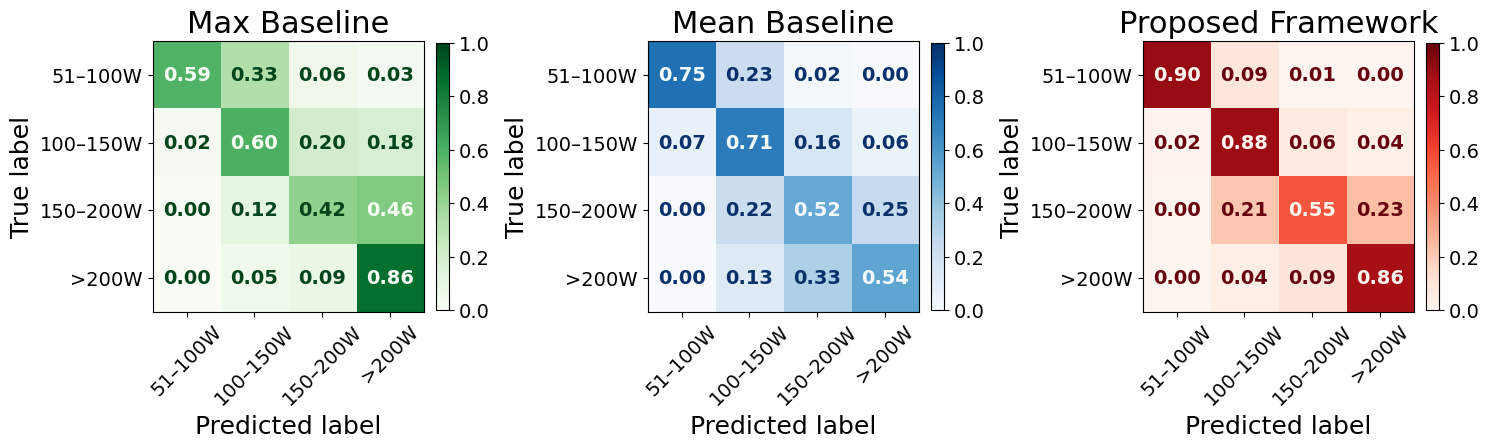

In [2]:
# VASP - max
cm_max = np.array([
    [21403, 11855,  2087,   944],
    [ 3043, 91929, 31017, 28135],
    [  177,  7828, 27891, 30768],
    [   90,  5028,  8011, 78877]
])

# VASP - mean
cm_mean = np.array([
    [27238,  8269,   631,   151],
    [11303,108948, 24185,  9688],
    [  326, 14912, 34800, 16626],
    [  171, 11853, 30513, 49469]
])


# VASP - lgb
cm_lgb = np.array([
    [32712,  3259,   194,   124],
    [ 2397,136368,  9681,  5681],
    [  290, 13884, 36825, 15665],
    [   54,  3942,  8584, 79426]
])


cms = [cm_max, cm_mean, cm_lgb]
titles = ['Max Baseline', 'Mean Baseline', 'Proposed Framework']

cms_norm = [cm.astype(float) / cm.sum(axis=1, keepdims=True) for cm in cms]

label_names = ['51–100W', '100–150W', '150–200W', '>200W']
cmaps = ['Greens', 'Blues', 'Reds']

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

for ax, cm_norm, title, cmap in zip(axes, cms_norm, titles, cmaps):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_norm,
        display_labels=label_names
    )

    disp.plot(
        ax=ax,
        cmap=cmap,
        values_format=".2f",
        colorbar=False,
        text_kw={'fontsize': 14, 'fontweight': 'bold'}
    )

    im = ax.imshow(cm_norm, cmap=cmap, vmin=0, vmax=1)
    
    cbar = plt.colorbar(
        im,
        ax=ax,
        fraction=0.045,  
        pad=0.04 
    )
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=22)
    ax.set_xlabel('Predicted label', fontsize=18)
    ax.set_ylabel('True label', fontsize=18)
    ax.tick_params(axis='both', labelsize=14)

    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.savefig("cm_stage2_vasp.pdf", format="pdf", bbox_inches="tight")
plt.show()



Runtime Power Prediction Feature Importances from LightGBM 

In [3]:
map_col_names = {
    'nersc_ldms_dcgm_power_usage_t2':  r'$avg\_power_{t}$',
    'nersc_ldms_dcgm_power_usage_t1':  r'$avg\_power_{t-1}$',
    'nersc_ldms_dcgm_power_usage_t0':  r'$avg\_power_{t-2}$',
    
    'fb_free_t2': r'$fb\_free_{t}$',
    'fb_free_t1': r'$fb\_free_{t-1}$',
    'fb_free_t0': r'$fb\_free_{t-2}$',

    'fb_used_t2': r'$fb\_used_{t}$',
    'fb_used_t1': r'$fb\_used_{t-1}$',
    'fb_used_t0': r'$fb\_used_{t-2}$',

    'sm_active_t2': r'$sm\_active_{t}$',
    'sm_active_t1': r'$sm\_active_{t-1}$',
    'sm_active_t0': r'$sm\_active_{t-2}$',

    'tensor_active_t2': r'$tensor\_active_{t}$',
    'tensor_active_t1': r'$tensor\_active_{t-1}$',
    'tensor_active_t0': r'$tensor\_active_{t-2}$',

    'sm_occupancy_t2': r'$sm\_occupancy_{t}$',
    'sm_occupancy_t1': r'$sm\_occupancy_{t-1}$',
    'sm_occupancy_t0': r'$sm\_occupancy_{t-2}$',

    'dram_active_t2': r'$dram\_active_{t}$',
    'dram_active_t1': r'$dram\_active_{t-1}$',
    'dram_active_t0': r'$dram\_active_{t-2}$',
    
    'gpu_utilization_t2': r'$gpu\_utilization_{t}$',
    'gpu_utilization_t1': r'$gpu\_utilization_{t-1}$',
    'gpu_utilization_t0': r'$gpu\_utilization_{t-2}$',

    'mem_util_t0': r'$mem\_utilization_{t}$',

    'AI_fp64_t2': r'$AI\_fp64_{t}$',
    'AI_fp64_t1': r'$AI\_fp64_{t-1}$',
    'AI_fp64_t0': r'$AI\_fp64_{t-2}$',

    'nersc_ldms_dcgm_power_usage_t2':  r'$avg\_power_{t}$',
    'nersc_ldms_dcgm_power_usage_t1':  r'$avg\_power_{t-1}$',
    'nersc_ldms_dcgm_power_usage_t0':  r'$avg\_power_{t-2}$',

    'req_time_t2': 'Timelimit',
    'req_time_t1': 'Timelimit',
    'req_time_t0': 'Timelimit',
    'req_node_t2': 'ReqNode',
    'req_node_t1': 'ReqNode',
    'req_node_t0': 'ReqNode',
    'User_t2': 'User',
    'User_t1': 'User',
    'User_t0': 'User',
    'Account_t2': 'Account',
    'Account_t1': 'Account',
    'Account_t0': 'Account',
    'JobName_t2': 'JobName',
    'JobName_t1': 'JobName',
    'JobName_t0': 'JobName',
    
}


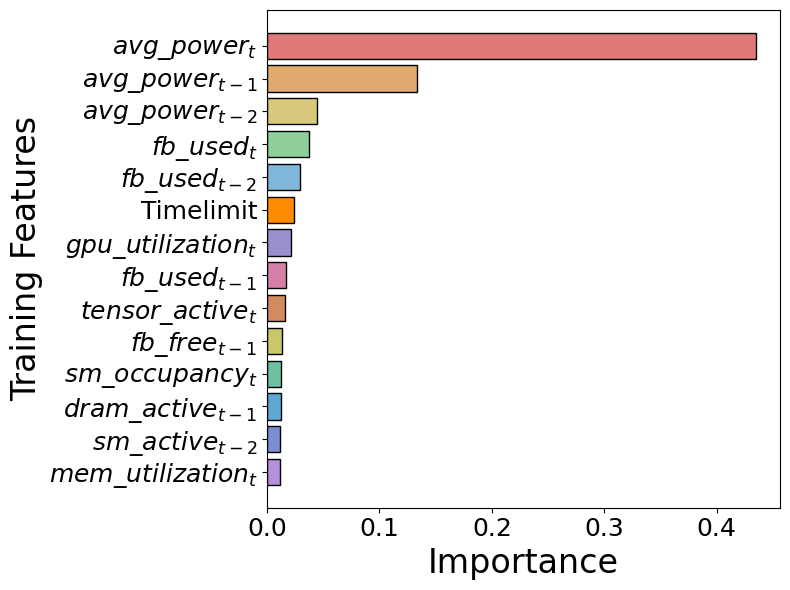

In [4]:
feature_importances = {
    "nersc_ldms_dcgm_power_usage_t2": 0.4347,
    "nersc_ldms_dcgm_power_usage_t1": 0.1331,
    "nersc_ldms_dcgm_power_usage_t0": 0.0443,
    "fb_used_t2": 0.0369,
    "fb_used_t0": 0.0296,
    "req_time_t0": 0.0242,
    "gpu_utilization_t2": 0.0211,
    "fb_used_t1": 0.0164,
    "tensor_active_t2": 0.0157,
    "fb_free_t1": 0.0131,
    "sm_occupancy_t2": 0.0125,
    "dram_active_t1": 0.0121,
    "sm_active_t0": 0.0119,
    "mem_util_t0": 0.0114,
}


sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_importances = [f[1] for f in sorted_features]
mapped_features = [map_col_names.get(f[0], f[0]) for f in sorted_features]


colors_14 = [
    "#E07A7A", 
    "#E0A96D",  
    "#D9C97C", 
    "#8FCF9C", 
    "#7FB7D8",
    "darkorange", #this matches the stage-1 results
    "#9B8FCF", 
    "#D67FA8", 
    "#D08C60", 
    "#C9C76A",
    "#6FBFA1", 
    "#5FA8D3", 
    "#7A8ED1",
    "#B58EDC",
    "#D17BA6", 
]


fig, ax2 = plt.subplots(1,1, figsize=(8,6))
ax2.barh(mapped_features, sorted_importances, color=colors_14, edgecolor='black')
ax2.invert_yaxis() 
ax2.set_xlabel('Importance', fontsize=24)
ax2.set_ylabel('Training Features', fontsize=24)
ax2.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.savefig("vasp_feat2.pdf", format='pdf', bbox_inches='tight')
plt.show()



In [5]:
mean_model_res = pd.read_pickle("/pscratch/sd/b/boztop/ml_training_files/vasp_Mean_results.pkl")
max_model_res = pd.read_pickle("/pscratch/sd/b/boztop/ml_training_files/vasp_Max_results.pkl")
lgb_model_res = pd.read_pickle("/pscratch/sd/b/boztop/ml_training_files/vasp_LGB_results.pkl")



In [6]:
# We need to do 3-zeros padding because of my mean and max model "training" in the runtime_power_pred.py file
y_pred = max_model_res["y_pred"]
zeros = np.zeros(3, dtype=y_pred.dtype) 

y_pred = np.concatenate([zeros, y_pred])

max_model_res["y_pred"] = y_pred

for k, v in max_model_res.items():
    if v is not None:
        print(k, len(v))
        

y_test 349086
y_train_cls 349083
y_pred 349086


In [7]:
y_pred = mean_model_res["y_pred"]
zeros = np.zeros(3, dtype=y_pred.dtype) 

y_pred = np.concatenate([zeros, y_pred])

mean_model_res["y_pred"] = y_pred


for k, v in mean_model_res.items():
    if v is not None:
        print(k, len(v))
        

y_test 349086
y_train_cls 349083
y_pred 349086


In [8]:
for k, v in lgb_model_res.items():
    if v is None:
        continue
    try:
        print(k, len(v))
    except TypeError:
        print(k, "has no length")
        

model has no length
X_test 349086
y_test 349086
y_train_cls 1625121
y_pred 349086
confusion_matrix 4
model_path 58


349086
349086
349086
 .. 


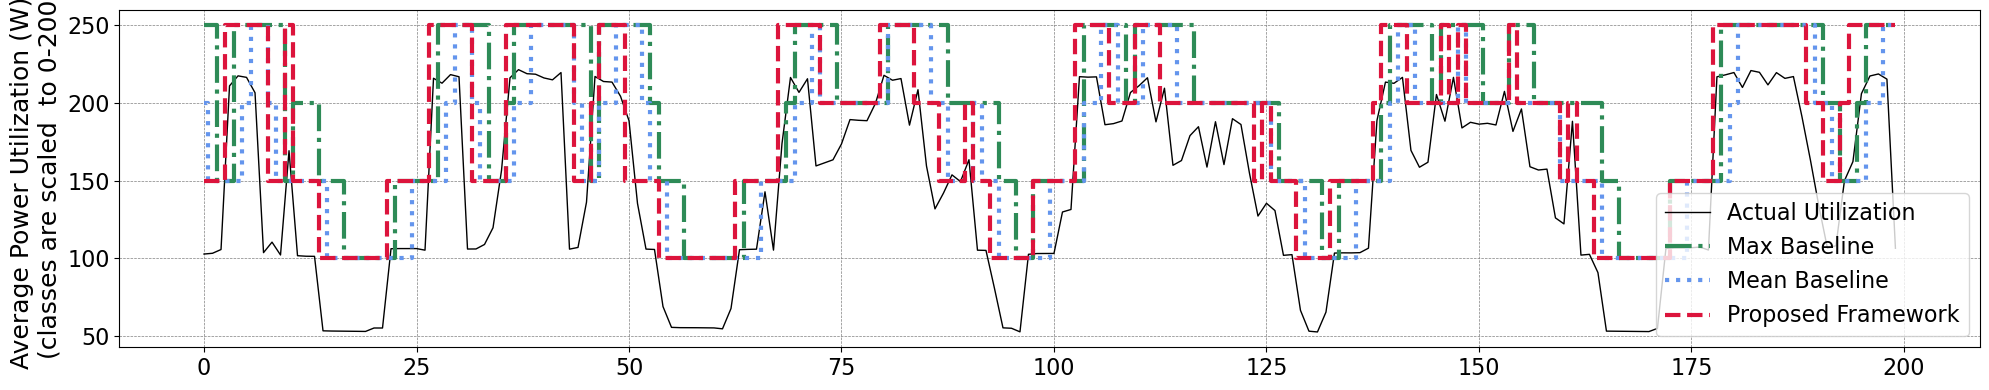

In [9]:
y_true_lgb  = lgb_model_res['y_test']
y_true_mean = mean_model_res['y_test']
y_true_max  = max_model_res['y_test']

y_pred_lgb  = lgb_model_res['y_pred']
y_pred_mean = mean_model_res['y_pred']
y_pred_max  = max_model_res['y_pred']

print(len(y_pred_mean))
print(len(y_pred_max))
print(len(y_pred_lgb))
print(" .. ")

n_points = 200
start_idx = 5000+500 # Can be anything, really.. I chose this part since the dynamic changes in power utilization is visible!
end_idx   = start_idx + n_points

y_true_plot  = y_true_lgb[start_idx:end_idx]
y_lgb_plot   = y_pred_lgb[start_idx:end_idx] * 50 + 100 # scale 0->200
y_mean_plot  = y_pred_mean[start_idx:end_idx] * 50 + 100 
y_max_plot   = y_pred_max[start_idx:end_idx] * 50 + 100 

x = np.arange(n_points)

plt.figure(figsize=(20,4))
plt.plot(x, y_true_plot, label='Actual Utilization', color='black', linewidth=1)

plt.step(x, y_max_plot, label='Max Baseline', color='seagreen', linestyle='-.', where='mid', linewidth=3)
plt.step(x, y_mean_plot, label='Mean Baseline', color='cornflowerblue', linestyle=':', where='mid', linewidth=3)
plt.step(x, y_lgb_plot, label='Proposed Framework', color='crimson', linestyle='--', where='mid', linewidth=3)

plt.ylabel('Average Power Utilization (W) \n (classes are scaled  to 0-200)', fontsize=18)
plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16,loc='best')
plt.grid(axis='both',color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig("example_run.pdf", format='pdf', bbox_inches='tight')
plt.show()
